# Deep Watching

In [15]:
import os
import json
from collections import defaultdict
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.manifold import Isomap
import pandas as pd
import matplotlib.colors as clrs
import spin as sp
classes = [
        "adler",
        "bandera1",
        "bandera2",
        "bandera3",
        "eu",
        "falanga",
        "flag_ru_hang",
        "flag_ru_fly",
        "flag_ru",
        "flag_ua_hang",
        "flag_ua_fly",
        "flag_ua",
        "flag_upa_hang",
        "flag_upa_fly",
        "flag_upa",
        "george_hang",
        "george_fly",
        "george_band",
        "george",
        "swastika",
        "hammer",
        "cross",
        "orthodox",
        "nato",
        "oun",
        "ss",
        "swoboda",
        "ukraine",
        "wolfsangel",
]

## Prepare data

In [3]:
# read individual json files
result_dir = "output"
results = []
counter = 0
for file in os.listdir(result_dir):
    if file.endswith(".json"):
        with open(result_dir + os.path.sep + file) as json_file:
            data = json.load(json_file)        
        for ann in data['annotations']:
            results.append({
                'file': file,
                'orig_file': data['file'],
                'frames': data['frames'],
                'fps': data['fps'],
                'width': data['width'],
                'height': data['height'],
                'frame_skip': data['frame_skip'],
                'width': data['width'],
                'frame_id': ann['image_id'],
                'category_id': ann['category_id'],
                'score': ann['score'],
                'bbox': ann['bbox'],
                'area': ann['area'],
            })

with open("results.json", 'w') as out_file:
    json.dump(results, out_file)

## Load data

In [16]:
data = pd.read_json('results.json')

## Corpus map using class counts

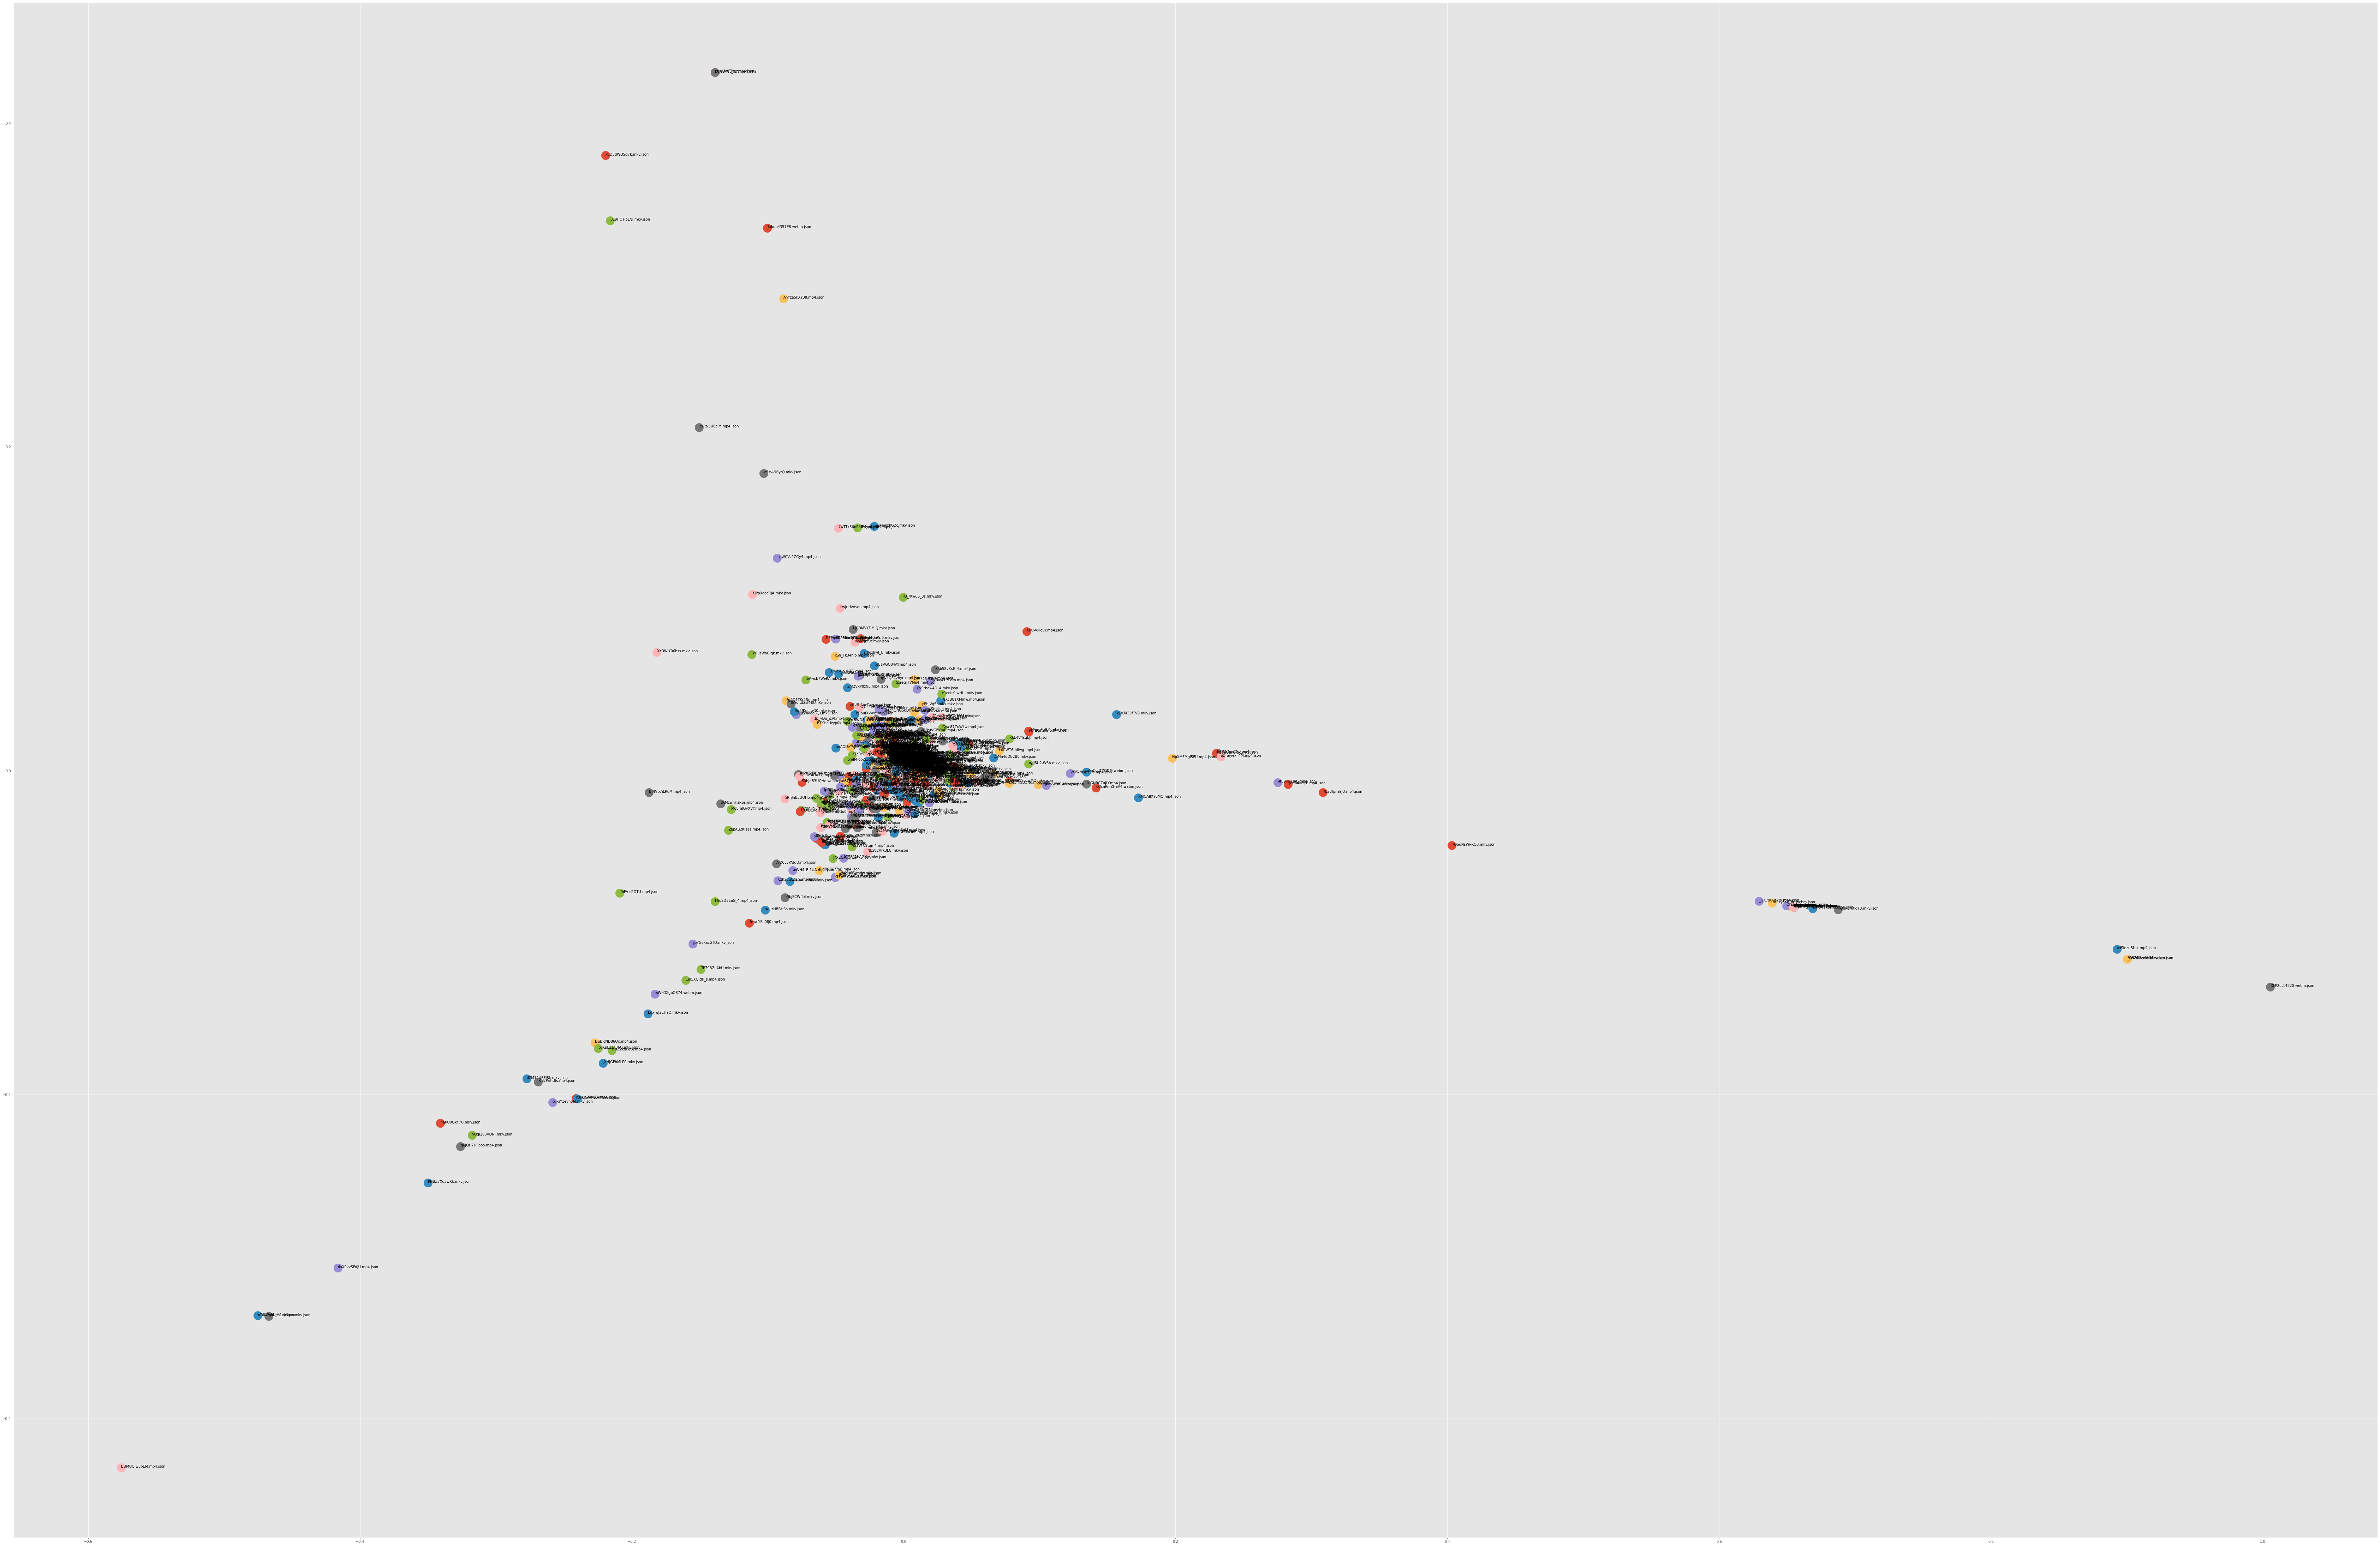

In [17]:
symbols_matrix = data.groupby(['file', 'category_id']).agg({'score': 'size', 'frames': 'mean'})
symbols_matrix['percentage'] = symbols_matrix['score'] / symbols_matrix['frames']
symbols_matrix = symbols_matrix.drop(columns=['score', 'frames'])
symbols_matrix = symbols_matrix.unstack().fillna(0)

matrix = symbols_matrix.to_numpy()

# create isomap
imap = Isomap()
corpus_map = imap.fit_transform(matrix)

# plot corpus using isomap
label_scale=0
fig = plt.figure(figsize=(120, 80))
ax1 = fig.add_subplot(111)
for counter in range(len(corpus_map)):
    scatter = ax1.scatter(corpus_map[counter][0], corpus_map[counter][1], marker='o', s=600)
    plt.annotate(symbols_matrix.index[counter], xy=(corpus_map[counter][0]+label_scale, corpus_map[counter][1]+label_scale))
plt.show()

## Symbol cooccurrences

/home/ghowa/working/bandera-demo/notebooks/spin.py:154: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dist_matrix = dist_matrix[np.meshgrid(si, si)]
/home/ghowa/working/bandera-demo/notebooks/spin.py:109: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  erg = np.trace(np.dot(dist_matrix[np.meshgrid(sorted_ind, sorted_ind)],


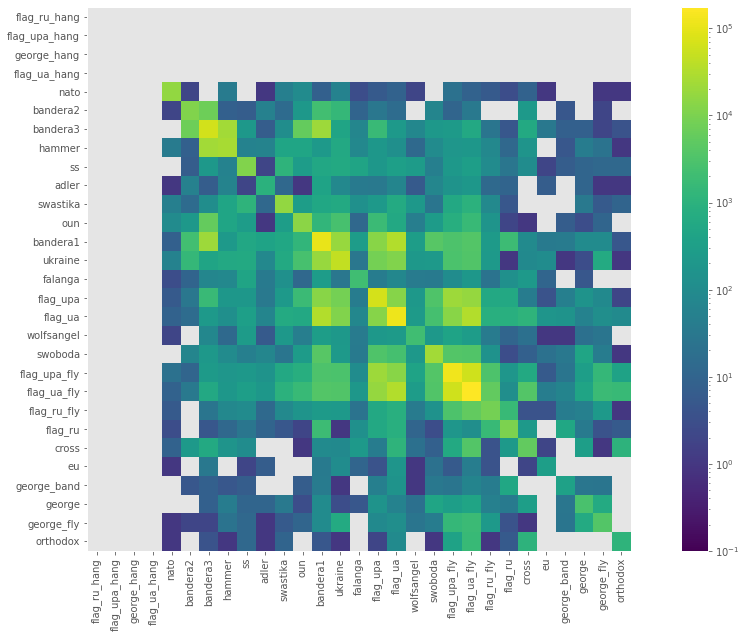

In [18]:
cat_num = data['category_id'].max() + 1 
cooc_count = np.zeros(shape=(cat_num, cat_num))
coocs = data.groupby(['file', 'frame_id'])['category_id'].apply(list)
for row in coocs:
    if len(row) > 1:
        for first in row:
            for second in row:
                cooc_count[first][second] += 1


#sort blogs with SPIN
order = np.array(range(len(cooc_count[0])))
new_cooc, new_order = sp.spin(cooc_count, order)

new_classes = []

for index in new_order:
    new_classes.append(classes[index])

fig, ax = plt.subplots(figsize=(18,10))
ax.grid(False)
plt.imshow(new_cooc, norm=clrs.LogNorm(vmin=0.1, vmax=cooc_count.max()),)
plt.colorbar()
plt.xticks(range(len(new_classes)), new_classes, rotation=90)
plt.yticks(range(len(new_classes)), new_classes)
plt.show()

## Annotations per video

In [ ]:
frames_per_vid = data.groupby(['file'])['frame_id'].apply(list)


In [ ]:
for index, item in frames_per_vid.iteritems():
    fig, ax = plt.subplots()
    ax.set(xlim=[0, max(item)])
    plt.title(index)
    plt.bar(item, [1])
    plt.show()